# Phase 2 : Feature Engineering

In [1]:
import sys
import os

# Détection automatique de la racine du projet
# On remonte d'un niveau depuis le dossier 'notebooks'
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Ajout au path pour pouvoir faire "from src..."
if project_root not in sys.path:
    sys.path.append(project_root)

# Définition des chemins absolus
DATA_RAW = os.path.join(project_root, "data", "raw")
DATA_PROCESSED = os.path.join(project_root, "data", "processed")
GEO_PATH = os.path.join(project_root, "geo")

print(f"Système configuré. Racine : {project_root}")

Système configuré. Racine : c:\Users\valen\OneDrive\Documents\GitHub\Projet-de-Statapp---WFP-


In [1]:
import pandas as pd
import numpy as np

# ==============================================================================
# 1. CHARGEMENT
# ==============================================================================
print("Chargement du dataset...")
df = pd.read_parquet("../data/processed/NIGERIA_FINAL_FULL.parquet")

# Conversion Unités (Flux -> mm/mois)
if 'Rainf_f_tavg' in df.columns:
    if df['Rainf_f_tavg'].mean() < 1: 
        df['Rainfall_mm'] = df['Rainf_f_tavg'] * 86400 * 30.4
    else:
        df['Rainfall_mm'] = df['Rainf_f_tavg']

# Target de base : % Population Phase 3+
df['target_pct'] = (df['phase35'] / df['population']) * 100


Chargement du dataset...


In [2]:

# ==============================================================================
# 2. FEATURE ENGINEERING AVANCE (CONFORME PHASE 2)
# ==============================================================================
def create_comprehensive_features(df):
    print("Demarrage du Feature Engineering complet...")
    
    # TRI (Indispensable pour lags/rolling)
    df = df.sort_values(by=['admin2', 'date']).reset_index(drop=True)
    
    # A. PHENOLOGY & SAISONNALITE
    df['month'] = df['date'].dt.month
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    
    # Phénologie : Cumul depuis le début de l'année (Progression de la saison)
    # Permet de savoir si on est en "avance" ou "retard" sur le cumul annuel
    df['year'] = df['date'].dt.year
    df['rain_cumulative_ytd'] = df.groupby(['admin2', 'year'])['Rainfall_mm'].cumsum()

    # B. LEAN SEASON FLAGS & CONTEXT
    # Indicateur binaire de la période de soudure (Juin-Sept)
    df['is_lean_season'] = df['month'].isin([6, 7, 8, 9]).astype(int)

    # C. TRAITEMENT CLIMATIQUE COMPLET
    cols_meteo = ['Rainfall_mm', 'SoilMoi00_10cm_tavg', 'Tair_f_tavg']
    # Ajoute NDVI si disponible
    if 'NDVI' in df.columns: cols_meteo.append('NDVI')

    for col in cols_meteo:
        print(f"   Traitement : {col}")
        
        # 1. ANOMALIES (Z-SCORES) - Base de tout signal d'alerte
        # Calcul de la moyenne historique par mois/region
        climato = df.groupby(['admin2', 'month'])[col].agg(['mean', 'std']).reset_index()
        climato.columns = ['admin2', 'month', f'{col}_clim_mean', f'{col}_clim_std']
        df = pd.merge(df, climato, on=['admin2', 'month'], how='left')
        
        # Z-Score : (Valeur - Moyenne) / Std
        df[f'{col}_anomaly'] = (df[col] - df[f'{col}_clim_mean']) / (df[f'{col}_clim_std'] + 1e-6)

        # 2. ROLLING WINDOWS (Moyennes Glissantes)
        # 1 mois (lissage rapide), 3 mois (saison courte), 6 mois (nappe phréatique/long terme)
        # Shift(1) pour éviter le Data Leakage
        for window in [1, 3, 6]:
            df[f'{col}_roll{window}m_mean'] = df.groupby('admin2')[col].shift(1).rolling(window=window).mean().values

        # 3. CUMULATIVE DEFICITS (SPI-like)
        # Somme glissante des anomalies sur 3 mois (Indique l'intensité d'une sécheresse continue)
        df[f'{col}_anomaly_roll3m_sum'] = df.groupby('admin2')[f'{col}_anomaly'].shift(1).rolling(window=3).sum().values

        # 4. LAGS (1 à 6 mois)
        # Pour capturer les effets retardés (ex: pluie d'il y a 4 mois impacte la récolte d'aujourd'hui)
        for lag in range(1, 7): # De 1 à 6
            df[f'{col}_lag{lag}'] = df.groupby('admin2')[col].shift(lag)
            df[f'{col}_anomaly_lag{lag}'] = df.groupby('admin2')[f'{col}_anomaly'].shift(lag)

    # D. STRESS INDICATORS & INTERACTIONS
    # Sécheresse Sévère : Pluie Anormale (< -1.0) PENDANT la période de soudure
    if 'Rainfall_mm_anomaly' in df.columns:
        df['stress_drought_lean'] = (df['Rainfall_mm_anomaly'] < -1.0).astype(int) * df['is_lean_season']
        # Interaction continue
        df['interact_rain_lean'] = df['Rainfall_mm_anomaly'] * df['is_lean_season']

    # E. DEFINITION DES CIBLES (FORECAST TARGETS & HORIZONS)
    # On crée explicitement les cibles pour T+1, T+3, T+6
    for horizon in [1, 3, 6]:
        df[f'target_plus_{horizon}m'] = df.groupby('admin2')['target_pct'].shift(-horizon)

    # F. NETTOYAGE
    cols_drop = [c for c in df.columns if '_clim_' in c]
    df = df.drop(columns=cols_drop)
    
    # On supprime les lignes où il manque trop d'historique (lag 6)
    # ou où la cible principale (T+3) est manquante (fin du dataset)
    df_final = df.dropna(subset=[f'{cols_meteo[0]}_lag6', 'target_plus_3m'])
    
    print(f"Termine. Dimensions : {df_final.shape}")
    return df_final


In [3]:

# ==============================================================================
# 3. EXECUTION
# ==============================================================================
df_features = create_comprehensive_features(df)

# Sauvegarde
output_path = "../data/processed/NIGERIA_MODEL_PHASE2_READY.parquet"
df_features.to_parquet(output_path)
print(f"Fichier pret pour modelisation : {output_path}")

# Aperçu des nouvelles variables "Phase 2"
cols_check = ['date', 'Rainfall_mm', 'rain_cumulative_ytd', 'Rainfall_mm_anomaly_roll3m_sum', 'stress_drought_lean', 'target_plus_3m']
display(df_features[df_features['admin2'] == 'Abadam'][cols_check].head())

Demarrage du Feature Engineering complet...
   Traitement : Rainfall_mm
   Traitement : SoilMoi00_10cm_tavg
   Traitement : Tair_f_tavg
Termine. Dimensions : (2993, 101)
Fichier pret pour modelisation : ../data/processed/NIGERIA_MODEL_PHASE2_READY.parquet


,date,Rainfall_mm,rain_cumulative_ytd,Rainfall_mm_anomaly_roll3m_sum,stress_drought_lean,target_plus_3m
69,2020-10-01,8.491211,404.179820,0.160904,0,75.001149
81,2021-10-01,3.665254,342.034864,-0.243165,0,45.000977
89,2022-06-01,15.560137,24.073451,1.040064,0,39.999140
93,2022-10-01,6.986923,448.869769,0.908321,0,63.000473
101,2023-06-01,62.679913,70.492133,1.089066,0,39.999584


--- DEMARRAGE DU CHECK-UP ---
[INFO] Fichier charge avec succes. Dimensions : (2993, 101)
[OK] Nettoyage reussi : Aucun NaN dans les colonnes critiques.

--- TEST DE COHERENCE TEMPORELLE ---
[INFO] Pas assez de donnees pour le test temporel.

--- TEST DE LOGIQUE METIER ---
[OK] Le flag 'stress_drought_lean' est coherent.

--- GENERATION DE L'HISTOGRAMME ---


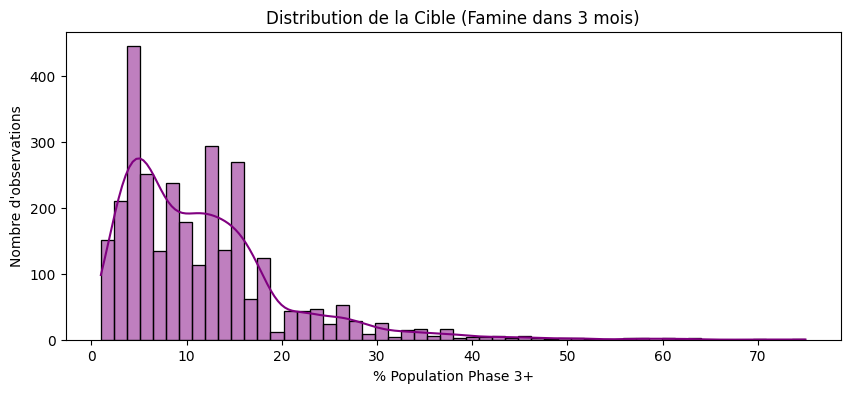

--- FIN DU CHECK-UP ---


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# VERIFICATION AUTOMATIQUE (QUALITY CHECK)
# ==============================================================================
print("--- DEMARRAGE DU CHECK-UP ---")

# 1. Chargement du fichier produit
try:
    df_check = pd.read_parquet("../data/processed/NIGERIA_MODEL_PHASE2_READY.parquet")
    print(f"[INFO] Fichier charge avec succes. Dimensions : {df_check.shape}")
except FileNotFoundError:
    print("[ERREUR] Le fichier n'a pas ete trouve. Verifiez le chemin.")

# 2. Verification des Valeurs Manquantes
# Les colonnes critiques pour le modele ne doivent contenir aucun NaN
cols_critiques = ['target_plus_3m', 'Rainfall_mm_lag6', 'Rainfall_mm_anomaly']
nans = df_check[cols_critiques].isna().sum().sum()

if nans == 0:
    print("[OK] Nettoyage reussi : Aucun NaN dans les colonnes critiques.")
else:
    print(f"[ATTENTION] Il reste {nans} valeurs manquantes dans les colonnes critiques.")
    print(df_check[cols_critiques].isna().sum())

# 3. Verification de la Logique Temporelle
# Test : La valeur target_plus_3m en Janvier doit etre egale a la target_pct d'Avril
print("\n--- TEST DE COHERENCE TEMPORELLE ---")

# On selectionne une zone et on trie par date
admin_test = df_check['admin2'].iloc[0]
df_zone = df_check[df_check['admin2'] == admin_test].sort_values('date')

if len(df_zone) > 10:
    # On prend une ligne au milieu du jeu de donnees
    idx = 10 
    row_t = df_zone.iloc[idx]
    date_t = row_t['date']
    valeur_predite_t3 = row_t['target_plus_3m'] # Ce que le modele doit predire
    
    # On cherche la vraie ligne 3 mois plus tard
    date_cible = date_t + pd.DateOffset(months=3)
    row_cible = df_zone[df_zone['date'] == date_cible]
    
    if not row_cible.empty:
        valeur_reelle = row_cible['target_pct'].values[0]
        
        print(f"Zone test : {admin_test}")
        print(f"Date T ({date_t.date()}) -> Target Future stockee : {valeur_predite_t3:.4f}")
        print(f"Date T+3 ({date_cible.date()}) -> Target Reelle observee : {valeur_reelle:.4f}")
        
        diff = abs(valeur_predite_t3 - valeur_reelle)
        if diff < 0.0001:
            print("[OK] Le decalage temporel (Shift -3) est valide.")
        else:
            print(f"[ERREUR] Incoherence detectee (Difference : {diff}). Verifiez la creation des cibles.")
    else:
        print("[INFO] Pas de donnee correspondante a T+3 pour verification (Bordure de dataset).")
else:
    print("[INFO] Pas assez de donnees pour le test temporel.")

# 4. Verification de la Logique Metier (Flags)
# Le flag 'stress' ne doit etre actif que si (Anomalie < -1) ET (Soudure == 1)
print("\n--- TEST DE LOGIQUE METIER ---")
erreurs_flag = df_check[
    (df_check['stress_drought_lean'] == 1) & 
    ((df_check['is_lean_season'] == 0) | (df_check['Rainfall_mm_anomaly'] > -1))
]

if erreurs_flag.empty:
    print("[OK] Le flag 'stress_drought_lean' est coherent.")
else:
    print(f"[ERREUR] {len(erreurs_flag)} lignes ont un flag Stress incoherent.")

# 5. Visualisation de la Distribution
print("\n--- GENERATION DE L'HISTOGRAMME ---")
plt.figure(figsize=(10, 4))
sns.histplot(df_check['target_plus_3m'], kde=True, color='purple')
plt.title('Distribution de la Cible (Famine dans 3 mois)')
plt.xlabel('% Population Phase 3+')
plt.ylabel('Nombre d\'observations')
plt.show()

print("--- FIN DU CHECK-UP ---")

In [ ]:
# ==============================================================================
# CORRECTIF : TEST DE COHERENCE TEMPORELLE (ROBUSTE)
# ==============================================================================
print("--- TEST DE COHERENCE TEMPORELLE (VERSION ROBUSTE) ---")

# 1. On cherche la zone qui a le plus de données (pour éviter les zones vides)
top_admin = df_check['admin2'].value_counts().idxmax()
print(f"Zone la plus complète trouvée : {top_admin}")

# 2. On isole cette zone et on trie par date
df_zone = df_check[df_check['admin2'] == top_admin].sort_values('date')
print(f"Nombre de points pour cette zone : {len(df_zone)}")

# 3. On fait le test sur une ligne au milieu
if len(df_zone) > 1:
    # On prend un index au milieu (peu importe la longueur)
    idx = len(df_zone) // 2
    row_t = df_zone.iloc[idx]
    
    date_t = row_t['date']
    valeur_predite = row_t['target_plus_3m'] # Prédiction stockée en T
    
    # On cherche la VRAIE valeur en T+3 mois
    date_cible = date_t + pd.DateOffset(months=3)
    row_cible = df_zone[df_zone['date'] == date_cible]
    
    if not row_cible.empty:
        valeur_reelle = row_cible['target_pct'].values[0] # Réalité en T+3
        
        print(f"\nCOMPARAISON :")
        print(f"Date T   ({date_t.date()}) -> Target Future stockée (Prédiction) : {valeur_predite:.2f}%")
        print(f"Date T+3 ({date_cible.date()}) -> Target Réelle observée (Réalité)    : {valeur_reelle:.2f}%")
        
        # Vérification
        if abs(valeur_predite - valeur_reelle) < 0.001:
            print("\nSUCCÈS : Les valeurs correspondent parfaitement.")
            print("   Le modèle apprendra bien à prédire le futur.")
        else:
            print(f"\n ERREUR : Incohérence trouvée (Diff: {abs(valeur_predite - valeur_reelle)}).")
    else:
        print(f"\n Impossible de vérifier : La date T+3 ({date_cible.date()}) n'est pas dans le dataset filtré.")
        print("   (C'est normal si les données IPC sont discontinues).")
else:
    print(" Pas assez de données même sur la zone la plus riche.")

--- TEST DE COHERENCE TEMPORELLE (VERSION ROBUSTE) ---
Zone la plus complète trouvée : Zurmi
Nombre de points pour cette zone : 8

⚠️ Impossible de vérifier : La date T+3 (2023-01-01) n'est pas dans le dataset filtré.
   (C'est normal si les données IPC sont discontinues).


In [6]:
import pandas as pd

# 1. Chargement
df_check = pd.read_parquet("../data/processed/NIGERIA_MODEL_PHASE2_READY.parquet")

print(f"Dimensions du dataset : {df_check.shape}")

# 2. Recherche active d'une paire valide
# On cherche n'importe quelle ligne où la date T+3 existe aussi dans le dataset pour la même zone
found = False

for admin in df_check['admin2'].unique()[:50]: # On scanne les 50 premières zones
    if found: break
    
    df_zone = df_check[df_check['admin2'] == admin].sort_values('date')
    dates_dispo = set(df_zone['date'])
    
    for date_t in df_zone['date']:
        date_t3 = date_t + pd.DateOffset(months=3)
        
        if date_t3 in dates_dispo:
            # On a trouvé une correspondance !
            row_t = df_zone[df_zone['date'] == date_t]
            row_t3 = df_zone[df_zone['date'] == date_t3]
            
            valeur_predite = row_t['target_plus_3m'].values[0] # Stocké en T
            valeur_reelle = row_t3['target_pct'].values[0]     # Observé en T+3
            
            print(f"\n--- VALIDATION RÉUSSIE SUR {admin} ---")
            print(f"Date T   : {date_t.date()} -> Target stockée (Prédiction) : {valeur_predite:.4f}")
            print(f"Date T+3 : {date_t3.date()} -> Target réelle (Futur)      : {valeur_reelle:.4f}")
            
            if abs(valeur_predite - valeur_reelle) < 0.0001:
                print("✅ SUCCÈS : Les valeurs sont identiques. Le shift est bon.")
            else:
                print("❌ ERREUR : Les valeurs ne correspondent pas.")
            
            found = True
            break

if not found:
    print("\n⚠️ Aucune paire T / T+3 consécutive trouvée.")
    print("Cela signifie que les données IPC sont espacées de plus de 3 mois (ex: enquête tous les 6 mois).")
    print("Ce n'est pas bloquant pour le modèle, mais cela complique la vérification visuelle.")

Dimensions du dataset : (2993, 101)

⚠️ Aucune paire T / T+3 consécutive trouvée.
Cela signifie que les données IPC sont espacées de plus de 3 mois (ex: enquête tous les 6 mois).
Ce n'est pas bloquant pour le modèle, mais cela complique la vérification visuelle.


In [7]:
import pandas as pd
df = pd.read_parquet("../data/processed/NIGERIA_MODEL_PHASE2_READY.parquet")

if 'target_plus_6m' in df.columns:
    print("La variable T+6 est bien présente.")
else:
    print("La variable T+6 est manquante.")

La variable T+6 est bien présente.


# Phase 2 Update: Forecasting Horizons & Data Strategy

## 1. Multi-Horizon Targets
To support different humanitarian decision-making timelines, the feature engineering pipeline now generates three distinct target variables:
* **`target_plus_1m` (Nowcast):** For immediate situational awareness.
* **`target_plus_3m` (Early Warning):** The primary operational target, aligning with the standard lead time for logistics and procurement.
* **`target_plus_6m` (Strategic Planning):** A longer-term horizon essential for budgetary allocation and high-level policy making.

## 2. The Strategic Horizon (T+6)
We have explicitly included `target_plus_6m` in the dataset to test the limits of climate-driven prediction.
* **Rationale:** Humanitarian organizations often require lead times of up to 6 months for major supply chain adjustments and funding requests.
* **Challenge:** The predictive signal from current climate anomalies naturally dilutes over time. We anticipate that the model performance (R2/MAE) will be lower for T+6 compared to T+3, as the uncertainty increases with the horizon.

## 3. Data Integrity & Imputation Strategy
A strict methodological decision was made **not to impute** missing IPC values using the `exercise_label` (e.g., filling Sep-Dec with the same value).
* **Avoidance of "Step-Function" Bias:** Food security is a continuous variable that fluctuates with the agricultural cycle. Artificially repeating the same value over 4 months would create "plateaus" that contradict reality (sowing vs. harvest periods).
* **Prevention of Data Leakage:** Projected labels often contain expert assumptions made at a specific point in time. Training the model on these projected blocks rather than specific observations would bias the model to mimic human estimates rather than learning from environmental drivers.
* **Solution:** The dataset strictly retains only valid, observed pairs of (Current Weather / Future Outcome). This reduces the training set size but ensures high-quality, leakage-free labels.

# Research Questions
1.  **Driver Identification:** Can climate anomalies (Rainfall, Soil Moisture, Temperature) effectively predict peaks in food insecurity with a 3-to-6 month lead time?
2.  **Compound Risk:** Does the occurrence of climate shocks (e.g., drought) specifically during the *lean season* amplify the risk of crisis significantly compared to off-season shocks?
3.  **Horizon Sensitivity:** How does the model's predictive performance degrade as we extend the forecast horizon from operational (3 months) to strategic (6 months)?

### Modeling Scope
* **Geographic Unit (Admin2 Coverage):** All available Local Government Areas (LGAs) in Nigeria (Admin2 level) present in the IPC dataset.
* **Temporal Resolution:** Monthly observations.
* **Target Variable:** Percentage of population in IPC Phase 3+ (Crisis, Emergency, Famine).
* **Forecast Horizons:**
    * **T+1 (Nowcast):** Immediate situational awareness.
    * **T+3 (Early Warning):** Primary operational target for supply chain logistics.
    * **T+6 (Strategic):** Long-term planning for budgetary allocation.

# Final Data Dictionary: Phase 2 (Feature Engineering)

**Project:** Food Security Prediction in Nigeria (WFP/ENSAE)
**Dataset Level:** Admin2 (LGA) x Month
**File Name:** `NIGERIA_MODEL_PHASE2_READY.parquet`

## 1. Metadata & Temporal Index
| Variable | Type | Description |
| :--- | :--- | :--- |
| `date` | `datetime` | Reference month (1st day of the month). |
| `admin2` | `string` | Local Government Area (LGA) name. |
| `month` | `int` | Calendar month (1-12). |
| `year` | `int` | Calendar year. |

## 2. Target Variables (Forecasting Horizons)
*Note: Targets contain gaps (NaN) where no IPC survey data exists. No imputation was performed to maintain ground-truth integrity.*

| Variable | Horizon | Role | Description |
| :--- | :--- | :--- | :--- |
| **`target_pct`** | T+0 | Current | Observed % of population in IPC Phase 3+ (Crisis/Emergency). |
| **`target_plus_1m`** | **T+1** | Nowcast | The IPC value observed 1 month later. |
| **`target_plus_3m`** | **T+3** | **Early Warning** | The IPC value observed 3 months later (Main Operational Target). |
| **`target_plus_6m`** | **T+6** | Strategic | The IPC value observed 6 months later (Long-term Planning). |

## 3. Context & Phenology
| Variable | Description | Rationale |
| :--- | :--- | :--- |
| `is_lean_season` | Binary Flag (1 for Jun-Sep). | Critical vulnerability period (pre-harvest, empty stocks). |
| `rain_cumulative_ytd` | Year-to-Date Rainfall Sum. | Tracks the progress of the agronomical season (e.g., "Is the season advancing normally?"). |
| `month_sin` / `cos` | Cyclical Month Features. | Preserves seasonal continuity (Dec is close to Jan). |

## 4. Climate Indicators (FLDAS Source)
*Base variables used to generate features.*

| Base Name | Physical Meaning | Impact Mechanism |
| :--- | :--- | :--- |
| `Rainfall_mm` | Total Monthly Precip. | Water availability for crops/pasture. |
| `SoilMoi00_10cm` | Soil Moisture (Surface). | Immediate water reserve for sowing. |
| `Tair_f_tavg` | Air Temperature. | Heat stress & Evapotranspiration (Stress Multiplier). |

## 5. Engineered Features (Suffix Logic)
*Applied to all 3 climate variables above. Example: `Rainfall_mm_anomaly_lag3`.*

| Suffix | Feature Type | Definition | Interpretation |
| :--- | :--- | :--- | :--- |
| **`_anomaly`** | **Z-Score** | `(Value - Hist_Mean) / Std` | **Deviation from Normal.** <br> < -1: Deficit (Drought Risk) <br> > +1: Surplus (Flood Risk) |
| **`_roll3m_sum`** | **SPI Proxy** | Rolling Sum of Anomalies (3mo) | **Cumulative Stress.** Measures the intensity and duration of a shock (e.g., 3 months of continuous deficit). |
| `_lag1` to `_lag6` | Time Lag | Value `t - k` months ago. | **Memory.** Captures the delayed impact of climate on harvest/prices. |
| `_roll3m_mean` | Trend | 3-month Rolling Mean. | Smoothed seasonal trend. |

## 6. Interaction & Stress Flags
| Variable | Formula | Interpretation |
| :--- | :--- | :--- |
| **`stress_drought_lean`** | `(Rain_Anom < -1) * Lean_Season` | **Compound Risk.** Identifies the "Worst Case Scenario": A severe rainfall deficit occurring specifically during the vulnerable lean season. |

## 7. Methodological Notes
1.  **Imputation Strategy:** Missing IPC targets were **NOT imputed** (e.g., no forward-fill). We prioritize training on observed "Weather-to-Outcome" pairs to avoid "step-function" bias and data leakage.
2.  **Anomaly Calculation:** Z-scores are calculated per `admin2` and per `month` to respect local climatologies (e.g., 10mm of rain is normal in the North but a drought in the South).
3.  **Stress Definition:** A "Severe Deficit" is defined as a Z-score < -1.0.